In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='100GB',
                       walltime="12:00:00")


/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43147 instead
  warnings.warn(


In [10]:
import dask
print(dask.__version__)
import distributed
print(distributed.__version__)
import dask_jobqueue
print(dask_jobqueue.__version__)

2021.04.0
2021.04.0
0.7.3


In [2]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:38189 Dashboard: http://128.104.200.53:43147/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
from scipy import optimize
from skimage import feature
from pylab import *
import struct
import math
import sys

#from skimage import data, color
from scipy import ndimage
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

sys.path.append('/srv/home/jwei74/hyperspy')
import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import time
import SeqIO
from SeqIO.version import __version__
from SeqIO.CeleritasSeqReader import SeqReader
from SeqIO.utils.file_utils import read_ref
import pyxem
from pyxem.signals.diffraction2d import *

### Load and visualizing

Load multi-dimentional data: for dask array in SeqIO and numpy array, the shaping is [fc, nav, nav, pc]; for hyperspy, it's different, [pc, nav, nav, fc]

In [5]:
folder ='/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211114/movie383/'
signal = SeqIO.load_folder(folder,lazy=True, chunk_shape=(1,128,128), nav_shape=(4,256,256))
signal.data

dask.array<get_image_chunk, shape=(4, 256, 256, 256, 256), dtype=float32, chunksize=(1, 128, 128, 256, 256), chunktype=numpy.ndarray>

In [6]:
# sum the frame cycle data to get better SNR for beam center
signal_sum = signal.sum(axis = 2)
signal_sum.data

,Array,Chunk
Bytes,16.00 GiB,16.00 MiB
Shape,"(256, 256, 256, 256)","(32, 32, 64, 64)"
Count,13362 Tasks,1024 Chunks
Type,float32,numpy.ndarray


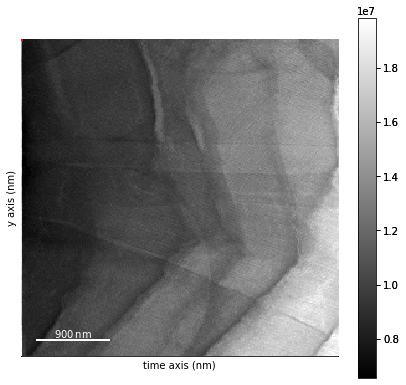

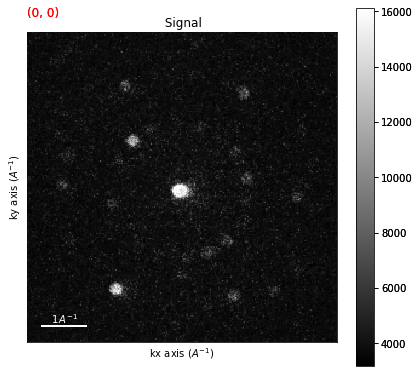

In [204]:
signal_sum.plot()

In [11]:
HAADF = hs.load('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211114/region20K_1.ser')
HAADF.axes_manager

Signal axis name,size,offset,scale,units
x,512,-1.9964861843156046e-06,7.79877415748283,nm
y,512,-1.9964861843156046e-06,7.79877415748283,nm


In [7]:
signal_sum.axes_manager['time'].units = 'nm' 
signal_sum.axes_manager['time'].scale = 7.79877*2 # need to recalibrate
signal_sum.axes_manager['y'].units = 'nm' 
signal_sum.axes_manager['y'].scale = 7.79877*2  # need to recalibrate
signal_sum.axes_manager

<Axes manager, axes: (256, 256|256, 256)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
            time |    256 |      0 |       0 |      16 |     nm 
               y |    256 |      0 |       0 |      16 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |    256 |        |       0 |       1 | <undefined> 
              ky |    256 |        |       0 |       1 | <undefined>

### lazysignal.compute() and lazysignal.data.compute() don't work for the zarr-version hyperspy

In [7]:
signal_sum.set_signal_type('electron_diffraction') # needed
signal_sum.set_diffraction_calibration(0.027776)
signal_sum.compute()
#signal_slice.data[signal_slice.data<7] = 0
#signal_sum = signal_sum/241 # you cannot do the integration before thresholding

<IPython.core.display.Javascript object>


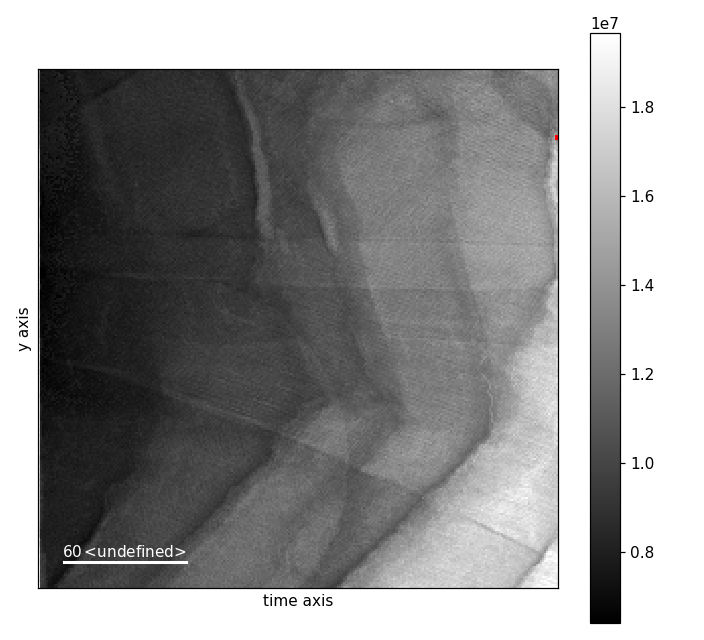

<IPython.core.display.Javascript object>


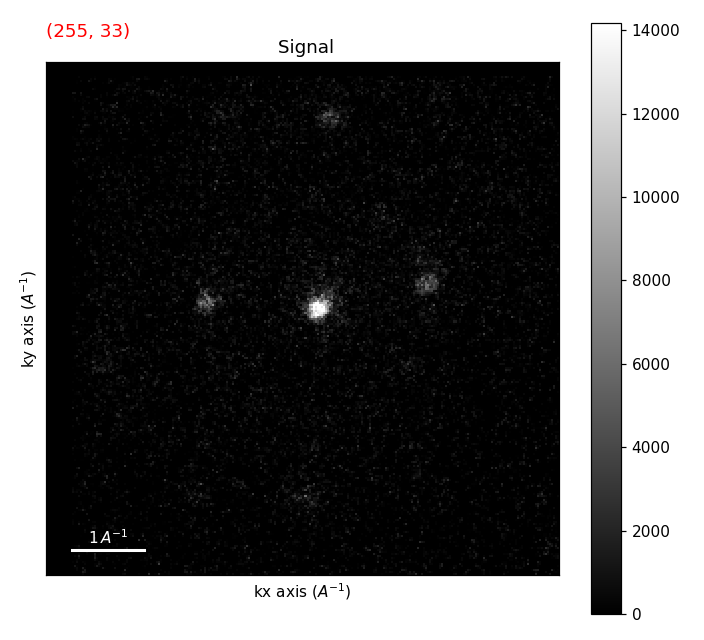

In [20]:
signal_reg.plot()

<IPython.core.display.Javascript object>


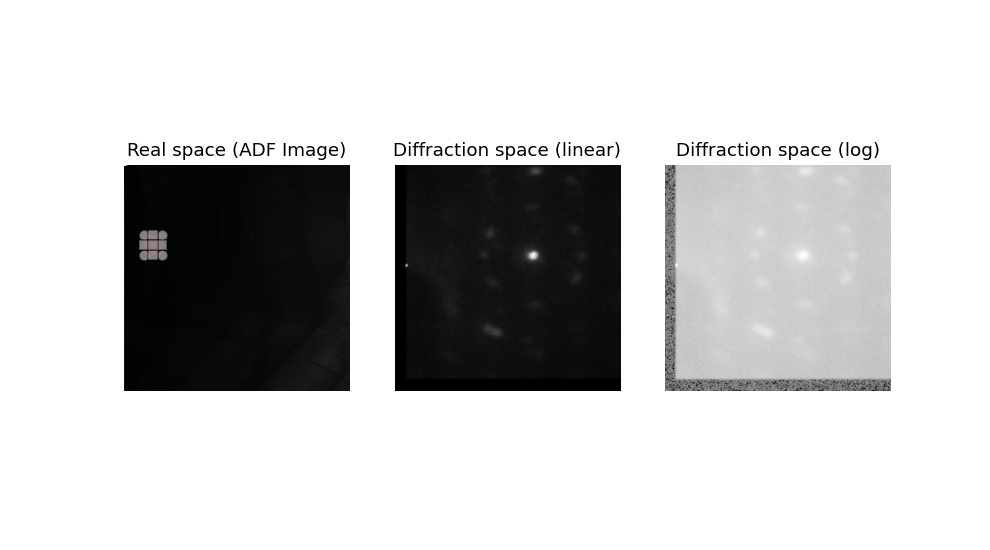

In [22]:
%matplotlib notebook
from ptycho_recon import browser
guis=browser.browser(signal_reg.data)

### Center zero beam in DP

In [9]:
signal_masked = signal_sum.threshold_and_mask(threshold=None, mask=(128,128,64))


  0%|          | 0/65536 [00:00<?, ?it/s]

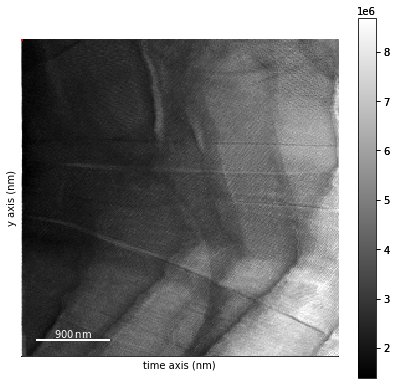

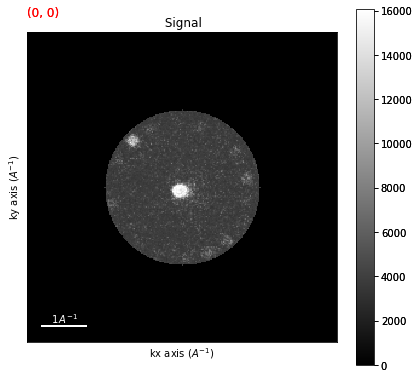

In [207]:
signal_masked.plot()

In [10]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def gaussiancenter(sample, sigma, threshold_peak):
    '''
    just gaussian blurred image max peak position
    gaussian fit is too complex 
    '''

    imgaussian = ndi.gaussian_filter(sample, sigma = sigma)
    coordinates = peak_local_max(imgaussian, min_distance = 100, threshold_abs = threshold_peak).ravel()

    if coordinates.shape[0] == 0:
        return imgaussian.shape[0]/2+1, imgaussian.shape[1]/2+1

    #plt.imshow(imgaussian)
    #plt.scatter(coordinates[1],coordinates[0], s = 1, c = 'r')
    #plt.colorbar()
    return coordinates


In [321]:
center = np.zeros((256,256,2))

for irow in range(256):
    for icol in range(256):
        sample = signal_masked.data[irow, icol, :,:]
        center[irow,icol] = gaussiancenter(sample, sigma = 3, threshold_peak = 700)
        #print(center[irow,icol])
    if irow % 10 == 0:
        print('Finish row', irow) 

Finish row 0
Finish row 10
Finish row 20
Finish row 30
Finish row 40
Finish row 50
Finish row 60
Finish row 70
Finish row 80
Finish row 90
Finish row 100
Finish row 110
Finish row 120
Finish row 130
Finish row 140
Finish row 150
Finish row 160
Finish row 170
Finish row 180
Finish row 190
Finish row 200
Finish row 210
Finish row 220
Finish row 230
Finish row 240
Finish row 250


In [322]:
np.save(folder+'gaussiancenter.npy', center)

### <span style="color:red"> Some frames (lefttop in r-space shown below) doesn't contains zero beam, probably because sample too thick. Applied zero shift for those frames</span> <br> 


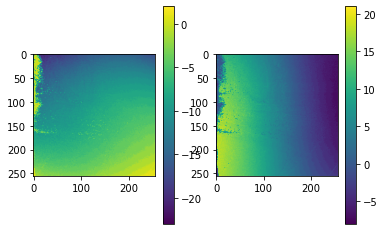

In [10]:
center = np.load(folder+'gaussiancenter.npy')
shift_x = center[:,:,0]-129
shift_y = center[:,:,1]-129
fig = plt.figure()
plt.subplot(121)
plt.imshow(shift_x)
plt.colorbar()
plt.subplot(122)
plt.imshow(shift_y)
plt.colorbar()

In [11]:

signal_reg = signal_sum.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                          parallel=True,inplace=False,show_progressbar=True)

  0%|          | 0/65536 [00:00<?, ?it/s]

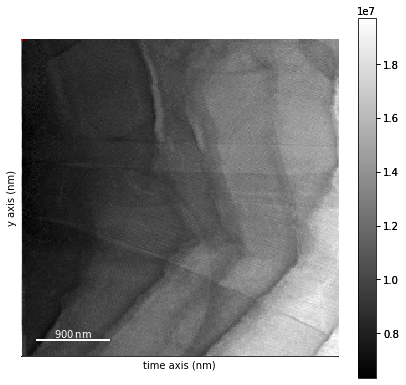

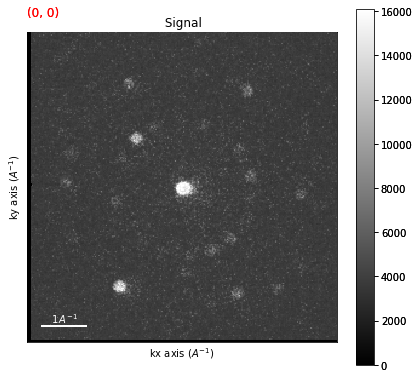

In [19]:
signal_reg.plot()

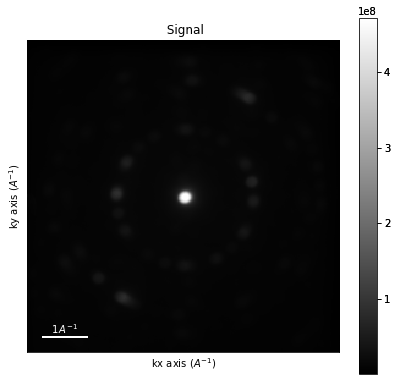

In [18]:
PACBED = signal_reg.sum(axis = (0,1))
PACBED.plot()
from PIL import Image
img = Image.fromarray(PACBED.data,'F')
img.save(folder+'pacbed.tif')

In [18]:
#haadf.axes_manager
haadf200.axes_manager

Signal axis name,size,offset,scale,units
x,512,-7.985944737262418e-06,31.19509662993132,nm
y,512,-7.985944737262418e-06,31.19509662993132,nm


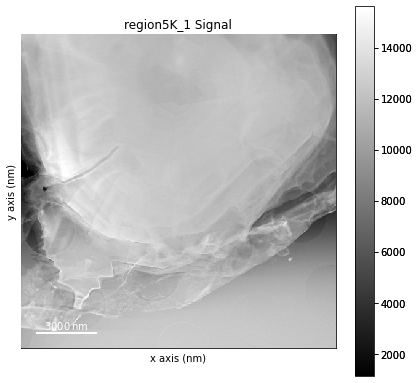

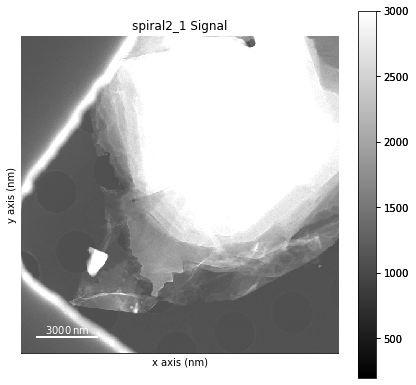

In [24]:
haadf = hs.load('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211114/region5K_1.ser')
haadf200 = hs.load('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211114/spiral2_1.ser')
haadf.plot()
#haadf200.map(scipy.ndimage.rotate, angle=0, reshape=False)
haadf200.plot(vmax=3000, vmin = 200)

In [20]:
for fc in np.arange(20):
    signal.inav[:,:,fc].save(folder + 'standard_integration_registered_fc'+str(fc)+'.hdf5')

In [19]:
(signal_sum/241).save(folder + 'sum_standard_integration_registered.hdf5')

In [15]:
folder ='/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211017/movie333/'
s = hs.load(folder + 'threshold_integration_registered.hdf5', lazy=True)
# should add a chunk step
#pacbed = s.sum(axis=(0,1,2))
#pacbed.compute(close_file=True)

,Array,Chunk
Bytes,40.00 GiB,512.00 kiB
Shape,"(5, 128, 128, 256, 256)","(1, 1, 1, 256, 256)"
Count,81921 Tasks,81920 Chunks
Type,float64,numpy.ndarray


#### Tensor SVD

In [ ]:
# Define the number of components that will be returned from scree_plots function, if ndim is not defined, ncomponents along
# each dimension will be set to the full size of that dimension

ndim = [128,128,65536]

scree = scree_plots(np.resize(signal_sum.data,(128,128,65536)),ndim)

# Plot the first 30 components along each dimension in log scale

for i in range(len(scree)):
    plt.plot(np.log(scree[i][0:100]),'.',linewidth = 4, label = 'dim' + str(i))
plt.legend(fontsize=16)
plt.xlabel('# Component', fontsize=16)
plt.ylabel('log(variance)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
rank = [15,15,10,10]
data_denoised = tensor_svd_denoise(signal_sum.data,rank)
data4D = np.resize(data_denoised,(128,128,256,256))
plt.imshow(data4D[10,10,:,:], cmap = 'gray')

In [ ]:
data_denoised.resize

In [ ]:
data4D.shape

In [ ]:
hyperspy.learn.svd_pca.svd_pca(data, output_dimension=None, svd_solver='auto', centre=None, auto_transpose=True, svd_flip=True, **kwargs)

### Labeling

In [82]:
red = [139,31]
orange = [134,32]
yellow = [136,33]
green = [160,36]
cyan = [169,40]
blue = [177,45]
purple = [181, 47]
black = [186,50]
white = [197,59]
pink = [205,68]
lis = [red,orange,yellow,green,cyan,blue,purple,black,white,pink]

[134, 32]

In [17]:
slice1 = s.inav[:,:,0]
slice1.data = slice1.data.astype(np.float32)
#slice1.data.rechunk((32,32,256,256))
slice1.data

,Array,Chunk
Bytes,4.00 GiB,256.00 kiB
Shape,"(128, 128, 256, 256)","(1, 1, 256, 256)"
Count,114689 Tasks,16384 Chunks
Type,float32,numpy.ndarray


In [18]:
slice1.compute()

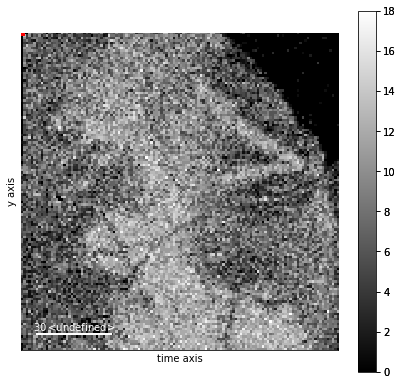

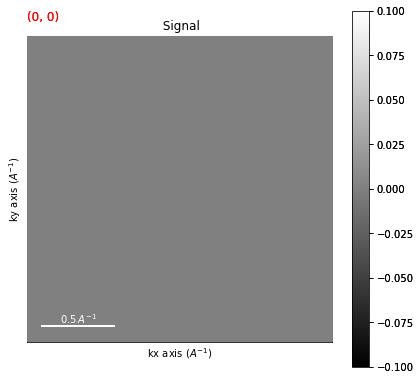

In [93]:
#red,orange,yellow,green,cyan,blue,purple,black,white,pink
(cx, cy) = np.asarray(pink)
s_out = slice1.threshold_and_mask(mask=(cx,cy,6), threshold=3, show_progressbar=False)
s_out.plot()
np.save('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211017/movie333/pink.npy',s_out.data[1:,1:])

0
1
2
3
4
5
6
7
8
9


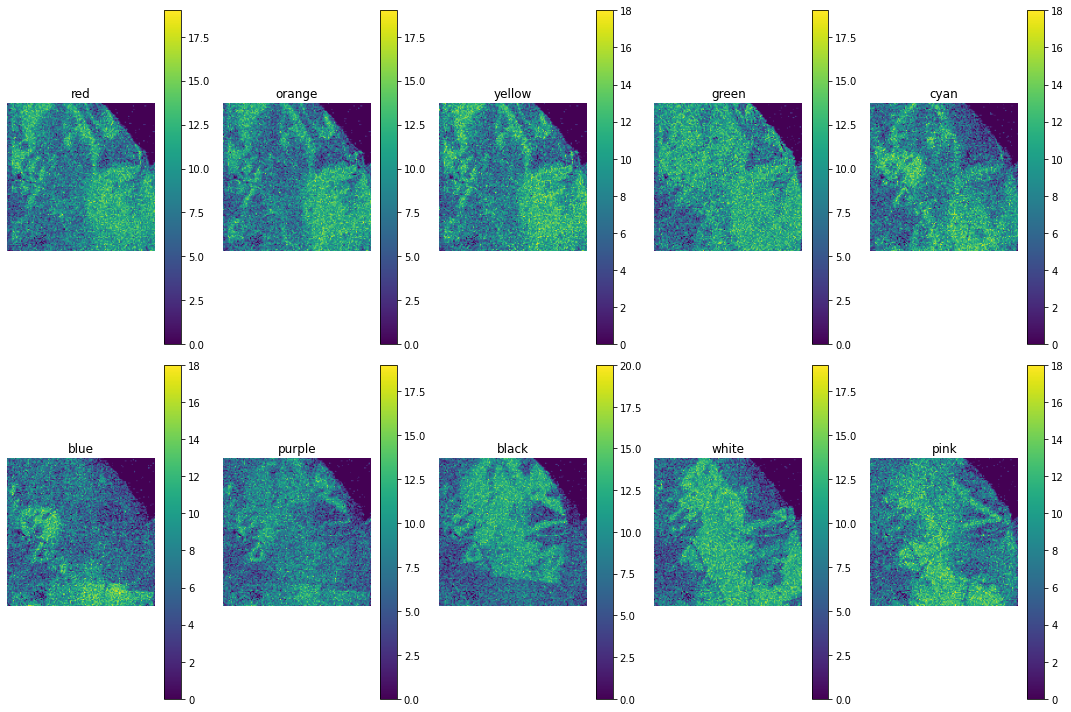

In [3]:
folder = '/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211017/movie333/'
fig = plt.figure(figsize=(15,10))

color = ['red','orange','yellow','green','cyan','blue','purple','black','white','pink']
for i in range(len(color)):
    print(i)
    fig.add_subplot(2,5,i+1)
    array = np.load(folder + color[i]+'.npy')
    plt.imshow(array.sum(axis = (2,3)))
    cbar = plt.colorbar()
    #cbar.ax.tick_params(labelsize=14)
    plt.axis('off')
    plt.title(color[i])

plt.tight_layout()

### Back up

In [25]:
# Apply Hough transform to detect disks from PACBED
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk
from skimage.feature import canny
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

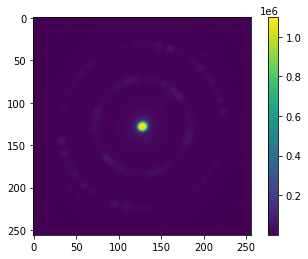

In [26]:
#pacbed = signal_sum.sum(axis = [0,1])
plt.imshow(pacbed)
plt.colorbar()

Text(0.5, 1.0, 'Canny edge detection')

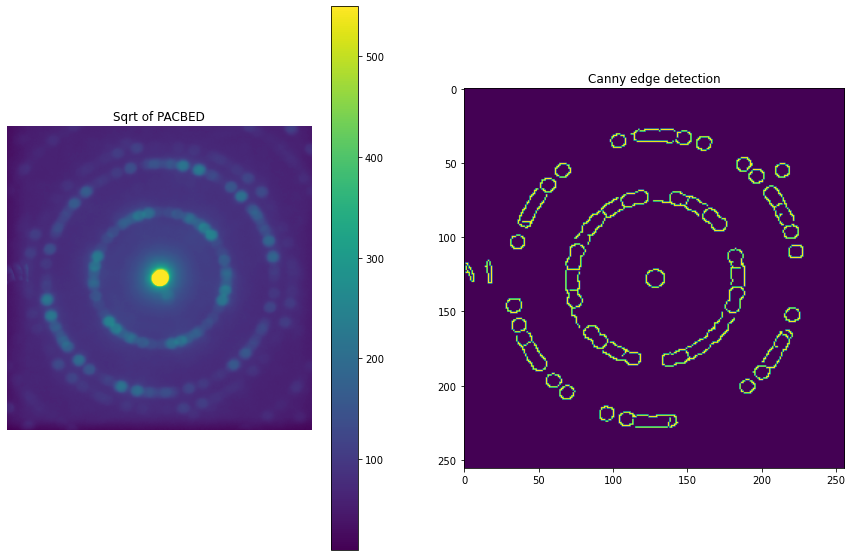

In [118]:
# Canny edge detection
fig = plt.figure(figsize=(15,10))
fig.add_subplot(121)
# selem = disk(4)
temp = pacbed.data
temp[temp<0]=0
plt.imshow(np.sqrt(temp), vmax = 550)
plt.title('Sqrt of PACBED')
plt.axis('off')
plt.colorbar()

fig.add_subplot(122)
temp = pacbed.data
plt.imshow(canny(np.sqrt(temp),sigma=0,low_threshold=40,high_threshold=110))# 300 1000
plt.title('Canny edge detection')
#plt.plot((60,70), (50,50), '-', c = 'r')

In [127]:
imgdata = np.sqrt(temp).astype('uint16')
Image.fromarray(imgdata).save('/srv/home/jwei74/4DSTEMdata/TwistedWS2/20211017/movie333/pacbed.tif')

Deleted: 106


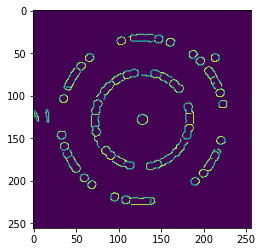

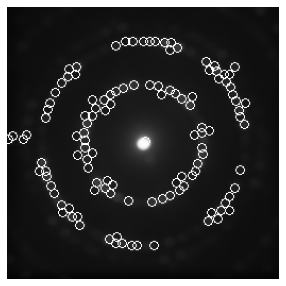

In [106]:
PACBED = pacbed.data
# Test Hough Transform to find circles
edges = canny(np.sqrt(temp),sigma=0,low_threshold=40,high_threshold=110)
plt.imshow(edges)
# Detect two radii
hough_radii = np.arange(4,5,1)
hough_res = hough_circle(edges, hough_radii)

# Select all the circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# delete the huge overlapped circles
del_index = []
limit = 5
import sklearn.metrics
dismatrix = sklearn.metrics.pairwise_distances(np.transpose((cx,cy)))
thresmatrix = dismatrix < limit
for i in range(cx.shape[0]):
  for j in range(i+1, cx.shape[0]):
    if thresmatrix[i,j]:
        del_index.append(j)
del_index = np.unique(del_index)
print('Deleted:', len(del_index))
if len(del_index) != 0:
    cxnew = np.delete(cx,del_index,0) 
    cynew = np.delete(cy,del_index,0)
    radiinew = np.delete(radii,del_index,0)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
PACBED_norm = PACBED / np.amax(PACBED)
PACBED_norm[PACBED_norm<0] = 0
PACBED_norm = np.sqrt(PACBED_norm)
image = color.gray2rgb(PACBED_norm)

for center_y, center_x, radius in zip(cynew, cxnew, radiinew):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20) #RGB value

ax.imshow(image, cmap=plt.cm.gray)

plt.axis('off')
plt.show()

cx_all = cx
cy_all = cy

In [ ]:
import logging

import numpy as np
from sklearn.utils.extmath import randomized_svd as fast_svd

_logger = logging.getLogger(__name__)

def tensor_svd_denoise(data, rank):
    """ Wrapper to pre-process STEM data for tensor SVD denoise
    Parameters
    ----------
    data : numpy array
        3D or 4D noisy input data with first two dimensions being navigation dimensions.
        3D data for hyperspectral data or 4D data with reciprocal space unfolded into one dimension, 4D data for original 4D STEM data.
    rank: numpy array
        Integer array (R1, R2, R3) denoise ranks for hyperspectral data or 4D STEM data, R1, R2 for real space dimensions, R3 for energy or k dimension.
        Three elements for both 3D and 4D input data.
        If rank is empty, scree_plot function will be called to run scree tests and generate scree plots to help user determine ranks to use..
    Returns
    -------
    X: numpy array
        Denoised data with low rank and the same size of input data.
    Future to do list:
    1. Roughly estimate noise level and determine the number of iterations to use in HOOI algorithm.
    2. Atuomatically determine denoising ranks from eigenvalues.
    """
    # Case when SVD ranks are fed in the input, call svd_HO function to denoise

    if len(data.shape) == 3:  # hyperspectral data case, directly feed data to svd_HO function
        [X, _, _] = svd_HO(data, rank)
    if len(data.shape) == 4:    # Original 4D STEM data case, unfold reciprocal space dimensions into one dimension then feed to svd_HO function
        data = np.reshape(data, [data.shape[0], data.shape[1], data.shape[2]*data.shape[3]])
        [X, _, _] = svd_HO(data, rank)
    
    return X



def svd_HO(data, rank, max_iter=10):
    """ HOOI method to decompose high order tensor with given ranks
    Parameters
    ----------
    data : numpy array
        Higher-order noisy tensor with size (I1 , I2 , ... , IN) along N dimensions. N >1.
    rank : numpy array
        Integer array (R1, R2, R3, ... , Rn) describes the eigenvectors for each dimension
    max_iter: integer
        Number of iterations for higher-order orthogonal iteration (HOOI) algorithm
    Returns
    -------
    X: numpy array
        Denoised tensor with low rank and the same size of input data.
    U: list of numpy array
        List of orthogonal matrix for each dimension, each component in the list has size Ik x Rk.
    S: numpy array
        Core tensor of the low rank tensor X with size (R1, R2, R3, ... , Rn).
    """
    svd_iter = 10
    data_shape = np.shape(data)         # p0

    # Check that number of dimensions match the number of rank numbers
    if len(data_shape) != len(rank):
        print("The rank should be the same size as the data shape")
        return data, [], []

    # Check that for each rank, the product of all the rest ranks are larger than this rank
    for k in range(len(rank)):
        prod = 1
        for i in range(len(rank)):
            if i != k:
                prod = prod * rank[i]
        if rank[k] > prod:
            print("The rank does not satisfy requirment of HOOI.")
            return data, [], []

    dimensions = len(data_shape)        # d
    ordered_indexes = np.argsort(data_shape) # getting the indicies from min len to max, initialization starts from smallest size

    ## Initialize U and Y with SVD
    U = [None] * dimensions # Generate an empty array to save all the U matrices with fixed length
    X = data
    for k in ordered_indexes: # calculating initial SVD
        unfolded = unfold_axis(X, k) # unfolding from the axis with minimum size
        [U[k], _ , _] = fast_svd(unfolded,rank[k],n_iter=svd_iter)
        X = ttm(X, np.transpose(U[k]), k) # This needs to be fixed!

    ## Update U with HOOI
    iter_count = 0
    while iter_count < max_iter:
        iter_count += 1
        for k in range(0, dimensions):
            Y = data
            minus_k = list(range(0,dimensions))
            minus_k.remove(k)  # every value except for k, seems do it in one step will remove all the elements in the list.
            for j in minus_k:
                Y = ttm(Y, np.transpose(U[j]), j)
            MY = unfold_axis(Y, k)
            [U[k], _, _] = fast_svd(MY, rank[k],n_iter=svd_iter)

    ## Use the determined U matrices to calculate core tensor and denoised tensor
    X = data
    for k in ordered_indexes:
        X = ttm(X,np.transpose(U[k]), k)  # Check this part.
    S = X   # core tensor
    for k in range(0,dimensions):
        X = ttm(X,U[k], k)

    return X, U, S

def unfold_axis(data, k):

    """ return matrix representation of a higher-order tensor along certain dimension
    Parameters
    ----------
    data : numpy array
        Higher-order tensor with size (I1 , I2 , ... , IN) along N dimensions.
    k : integer number
        Dimension index k (0 - N-1) along which the tensor will be unfolded
    Returns
    -------
    data_unfold : numpy array
        2D array with size (Ik, (I1 x I2 x ... x Ik-1 x Ik+1 x ... x IN))
        The second dimension is arranged in the order of k+1, k+2, ..., N, 1, 2, ..., k-1
    """

    target_dim = k
    total_dim = len(data.shape)

    dim_list = []
    for i in range(total_dim):
        dim_list.append((target_dim - i) % total_dim)
    dim_order = tuple(dim_list)

    data_unfold = np.transpose(data,dim_order)
    data_unfold = np.reshape(data_unfold,[data.shape[k],int(data.size/data.shape[k])])
    return data_unfold

def ttm(t, m, k):

    """ Preforms multiplication of a higher-order tensor by a matrix
    Parameters
    ----------
    t : numpy array
        Higher-order tensor with size (I1 , I2 , ... , IN) along N dimensions.
    m : numpy array
        2D matrix with size (Jk, Ik), the size of second dimension must be the same as the kth dimension in t, where k is the dimension index in the third input.
    k : integer
        Specify the dimension of t which will be multiplied by matrix m
    Returns
    -------
    t_mul : numpy array
        Higher-order tensor with size (I1 , I2 , ... , Ik-1, Jk, Ik+1, ... , IN) along N dimensions.
    """

    dim_list = []   # initialize a list to save dimension index to transpose the tensor reshapped from 2D matrix
    shape_list = [] # initialize a list to save the dimensions to reshape 2D matrix back to tensor
    total_dim = len(t.shape)
    for i in range(total_dim):
        dim_list.append((k - i) % total_dim)
        shape_list.append(t.shape[(k - i) % total_dim])
    dim_order = tuple(dim_list)
    shape_list[0] = m.shape[0]

    t_unfold = unfold_axis(t, k)
    t_mul = np.matmul(m, t_unfold)
    t_mul = np.reshape(t_mul,tuple(shape_list))
    t_mul = np.transpose(t_mul, dim_order)

    return t_mul

def scree_plots(t, ndim = []):
    
    """ Performs scree tests for each dimension of the input tensor
    Parameters
    ----------
    t : numpy array
        Higher-order tensor with size (I1 , I2 , ... , IN) along N dimensions.
    ndim : optional, list with N integer elements
        Number of components to calculate along each dimension. If not defined, the maximum size along each dimension will be used.
    Returns
    -------
    scree : list of N numpy arrays
        One array with size ndim[i] for each dimension saving the eigenvalues for this dimension.
    """
    total_dim = len(t.shape)
    if not ndim:   # case with no input ndim
        for i in range(total_dim):
            ndim.append(t.shape[i])
    elif len(ndim) != total_dim:    # case that input ndim does not agree with number of dimensions of the input tensor
        for i in range(total_dim):
            ndim.append(t.shape[i])
    else:   # check whether the number in ndim is less than the size of that dimension
        for i in range(total_dim):
            if ndim[i] > t.shape[i]:
                ndim[i] = t.shape[i]
    
    scree = []
    for i in range(total_dim):
        t_unfold = unfold_axis(t, i)
        [ _, e, _ ] = fast_svd(np.matmul(t_unfold,np.transpose(t_unfold)),ndim[i],n_iter=15)
        e = np.sqrt(e)
        e = np.real(e)
        scree.append(e)

    return scree

Different errors come out from these functions

In [88]:
shifts = signalref.get_direct_beam_position(method='blur', sigma=2, lazy_result=False)

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/distributed/protocol/core.py", line 72, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 292, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 298, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 295, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 202, in msgpack._cmsgpack.Packer._pack
ValueError: bytes object is too large
distributed.comm.utils 

CancelledError: ('subtract-b46ef02d24a08e9d135f9ef94cbe7a5e', 10, 15, 0)

In [89]:
shifts = signalref.center_direct_beam(method='blur', sigma=2,return_shifts=True)

TypeError: cannot pickle '_thread.lock' object